In [32]:
import os
import json
import numpy as np
import faiss

embedding_cache_path = '/mnt/data/data-selection/data/processed/sharegpt/embeddings.npy'
scores_path = '/mnt/data/data-selection/data/processed/sharegpt/scores.jsonl'
indices_path = {
    'KCenterGreedy': '/mnt/data/data-selection/selection/indices/sharegpt_KCenterGreedyDeita_0.05.pkl',
    'KMeansCentroid': '/mnt/data/data-selection/selection/indices/sharegpt_KMeansCentroidDeita_0.05.pkl',
    'KMeansRandom': '/mnt/data/data-selection/selection/indices/sharegpt_KMenasRandomDeita_0.05.pkl',
    'KMeansMedian': '/mnt/data/data-selection/selection/indices/sharegpt_KMenasMedianDeita_0.05.pkl'
}
random_k_path = {
    '1024' : '/mnt/data/data-selection/selection/indices/sharegpt_KMenasRandomDeita_1024_0.05.pkl',
    '512': '/mnt/data/data-selection/selection/indices/sharegpt_KMenasRandomDeita_512_0.05.pkl',
    '128': '/mnt/data/data-selection/selection/indices/sharegpt_KMenasRandomDeita_128_0.05.pkl',
    '64': '/mnt/data/data-selection/selection/indices/sharegpt_KMenasRandomDeita_64_0.05.pkl',
}

In [19]:
embeddings = np.load(embedding_cache_path)
scores = []
with open(scores_path) as f:
    for line in f:
        scores.append(json.loads(line))
embeddings.shape

(168864, 4096)

In [20]:
import pickle
indices = {}
for name, path in indices_path.items():
    indices[name] = pickle.load(open(path, 'rb'))['indices']

In [21]:
mat = faiss.PCAMatrix(embeddings.shape[1], 2)
mat.train(embeddings)

In [16]:
indices2embeddings = {}
for name, index in indices.items():
    indices2embeddings[name] = mat.apply(embeddings[index])

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
from matplotlib import rcParams


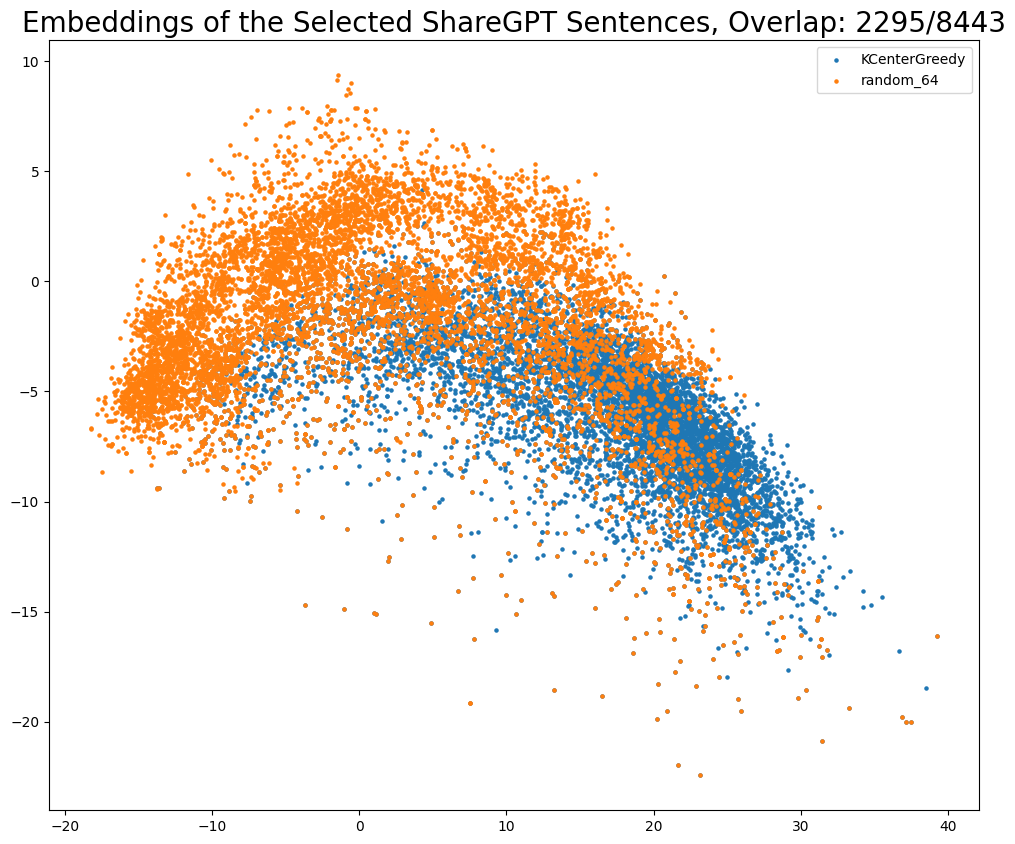

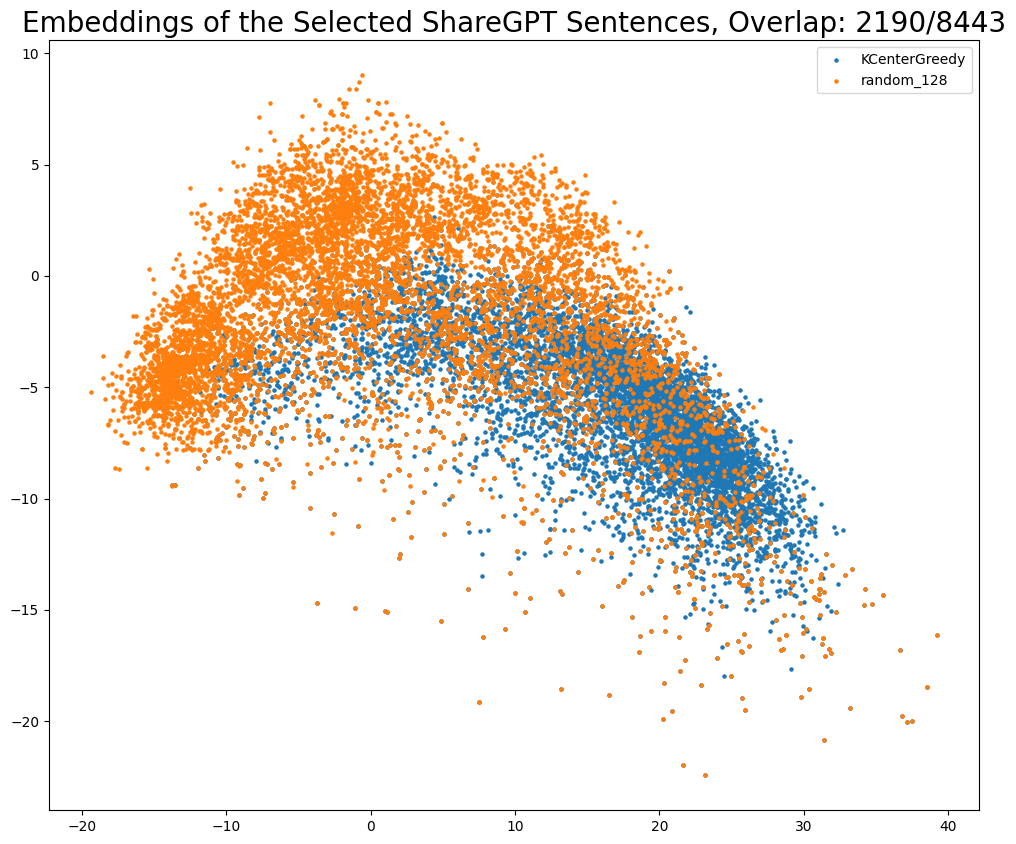

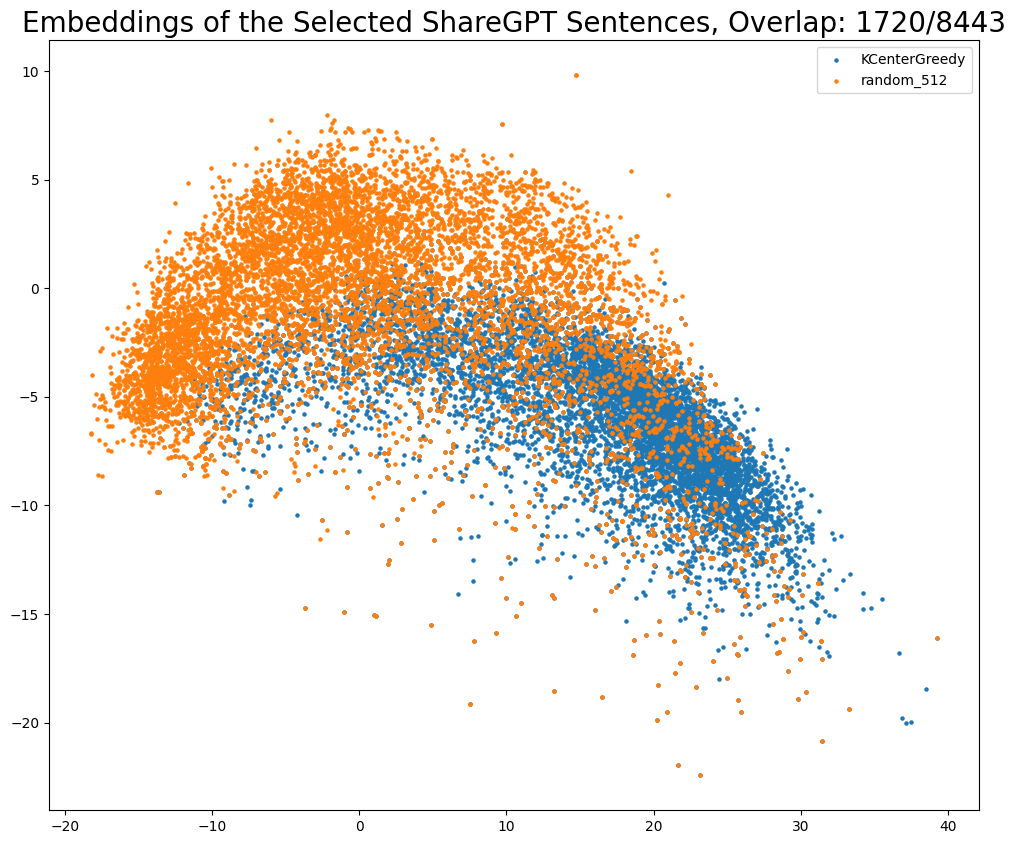

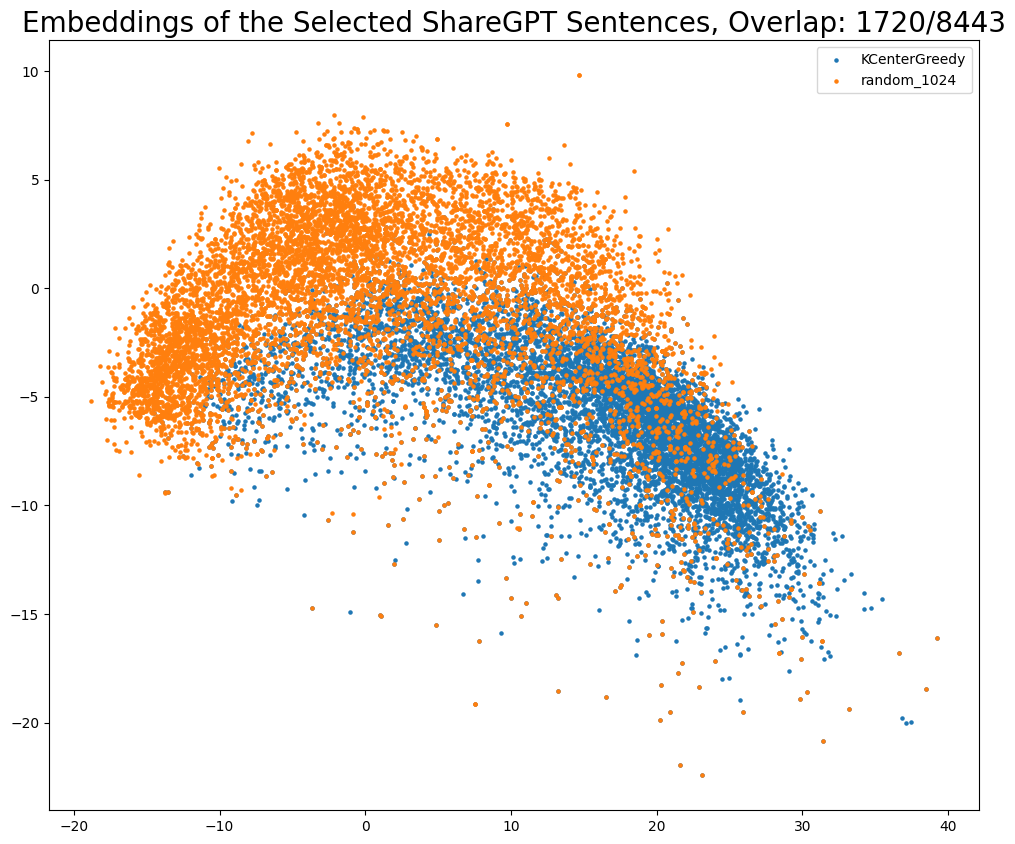

In [28]:
# plot the embeddings
for i in ['64', '128', '512', '1024']:
    indices2embeddings = {}
    indices2embeddings['KCenterGreedy'] = mat.apply(embeddings[pickle.load(open(indices_path['KCenterGreedy'], 'rb'))['indices']])
    indices2embeddings['random_' + i] = mat.apply(embeddings[pickle.load(open(random_k_path[i], 'rb'))['indices']])
    
    # compute the overlap of indices between KCenterGreedy and random
    overlap = set(pickle.load(open(random_k_path[i], 'rb'))['indices']) & set(pickle.load(open(indices_path['KCenterGreedy'], 'rb'))['indices'])
    len_overlap = len(overlap)

    fig, ax = plt.subplots(figsize=(12, 10))
    for name, embed in indices2embeddings.items():
        ax.scatter(embed[:, 0], embed[:, 1], label=name, s=5)
    ax.legend()
    # title
    plt.title('Embeddings of the Selected ShareGPT Sentences, Overlap: ' + str(len_overlap) + '/' + str(len(indices2embeddings['KCenterGreedy'])), fontsize=20)

/var/tmp/ipykernel_712252/3446093209.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories)


Text(0.5, 1.0, 'Sum of Scores of Selected Sentences')

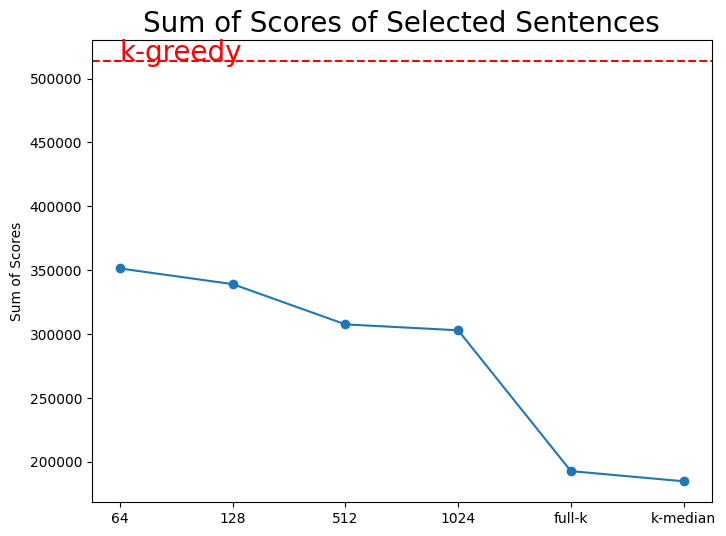

In [37]:
k2indices = {}
for k in ['64', '128', '512', '1024']:
    k2indices[k] = pickle.load(open(random_k_path[k], 'rb'))['indices']

k2indices['full-k'] = pickle.load(open(indices_path['KMeansCentroid'], 'rb'))['indices']
k2indices['k-greedy'] = pickle.load(open(indices_path['KCenterGreedy'], 'rb'))['indices']
k2indices['k-median'] = pickle.load(open(indices_path['KMeansMedian'], 'rb'))['indices']

# compute the sum of scores based on the indices
k2sum = {}
for k, indices in k2indices.items():
    k2sum[k] = sum([scores[i]['eval_score'] for i in indices])

# plot the sum of scores in line chart, with category ['64', '128', '512', '1024', 'full-k', 'k-median'], 'k-greedy' as a dashed straight line
fig, ax = plt.subplots(figsize=(8, 6))
k_greedy_score = k2sum['k-greedy']
k2sum.pop('k-greedy')
categories = ['64', '128', '512', '1024', 'full-k', 'k-median']
ax.set_xticklabels(categories)
ax.plot(categories, [k2sum[k] for k in categories], marker='o')
ax.set_ylabel('Sum of Scores')

# draw a horizontal line at k_greedy_score
ax.axhline(y=k_greedy_score, color='r', linestyle='--')
ax.text(0, k_greedy_score, 'k-greedy', fontsize=20, color='r')
plt.title('Sum of Scores of Selected Sentences', fontsize=20)

### Evol scores

Text(0.5, 1.0, 'Deita Evol score distribution')

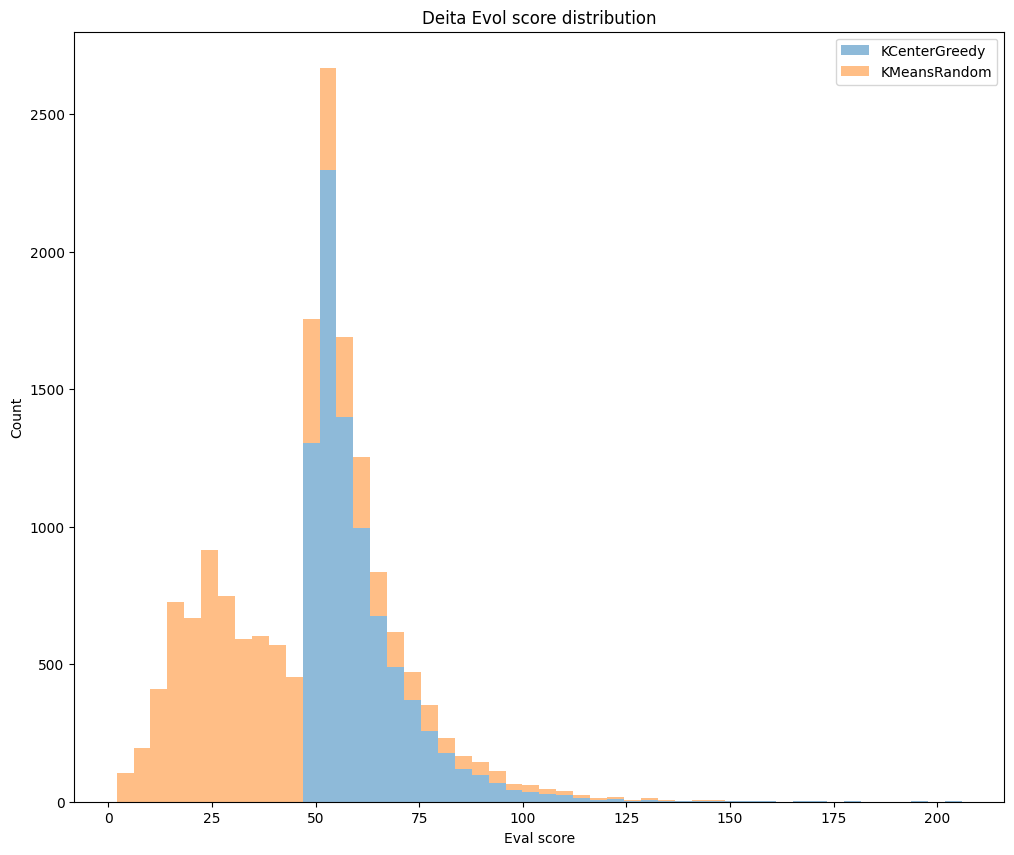

In [18]:
# plot the scores
eval_scores = np.array([score['eval_score'] for score in scores])
fig, ax = plt.subplots(figsize=(12, 10))
all_scores = []
names = []
for name, index in indices.items():
    index = np.array(index)
    name_scores = eval_scores[index]
    all_scores.append(name_scores)
    names.append(name)

# Plot the stacked histogram
ax.hist(all_scores, bins=50, label=names, alpha=0.5, stacked=True)
# ax.set_yscale('log')

ax.legend()
# x-axis title
ax.set_xlabel('Eval score')
# y-axis title
ax.set_ylabel('Count')
# title
ax.set_title('Deita Evol score distribution')

### Quality Scores

Text(0.5, 1.0, 'Deita Quality score distribution')

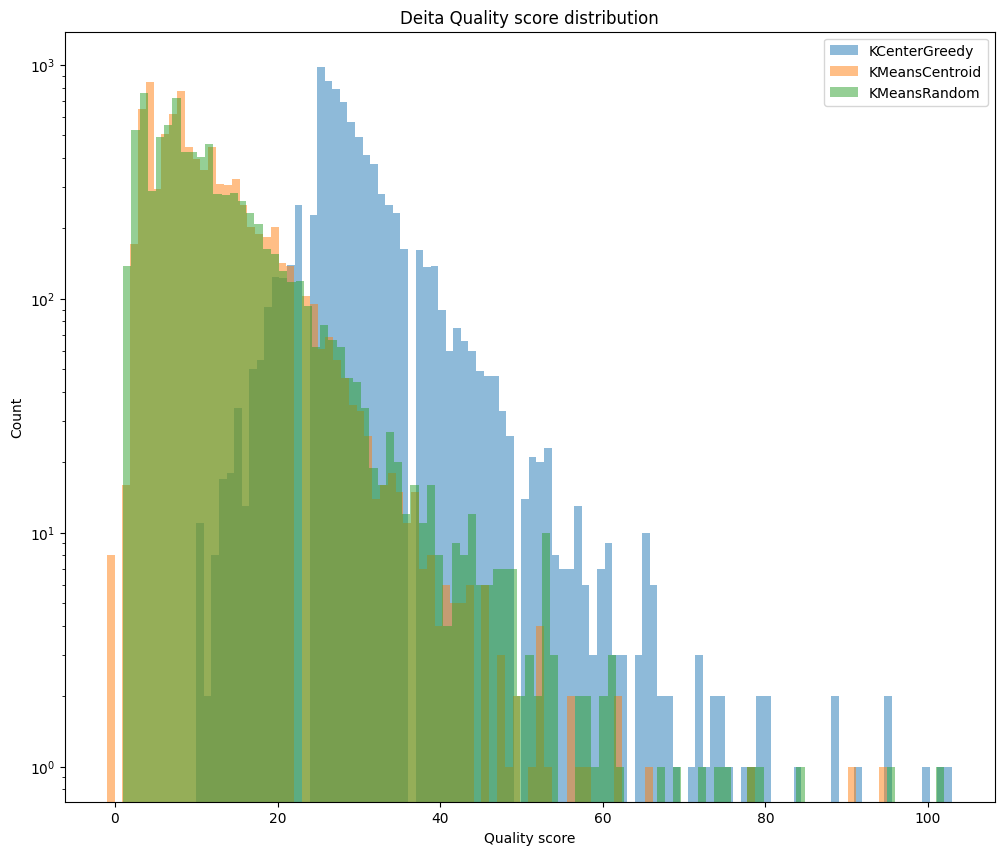

In [15]:
quality_scores = np.array([score['quality_score'] for score in scores])
fig, ax = plt.subplots(figsize=(12, 10))
for name, index in indices.items():
    index = np.array(index)
    name_scores = quality_scores[index]
    # plot the score distribution
    ax.hist(name_scores, bins=100, label=name, alpha=0.5)
    # y-axis log scale
    ax.set_yscale('log')
ax.legend()
# x-axis title
ax.set_xlabel('Quality score')
# y-axis title
ax.set_ylabel('Count')
# title
ax.set_title('Deita Quality score distribution')

### Different Random K clusters

In [29]:
import pickle
indices = {}
for name, path in random_k_path.items():
    indices[name] = pickle.load(open(path, 'rb'))['indices']

indices2embeddings = {}
for name, index in indices.items():
    indices2embeddings[name] = mat.apply(embeddings[index])

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
from matplotlib import rcParams


Text(0.5, 1.0, 'Embeddings of the Selected ShareGPT Sentences')

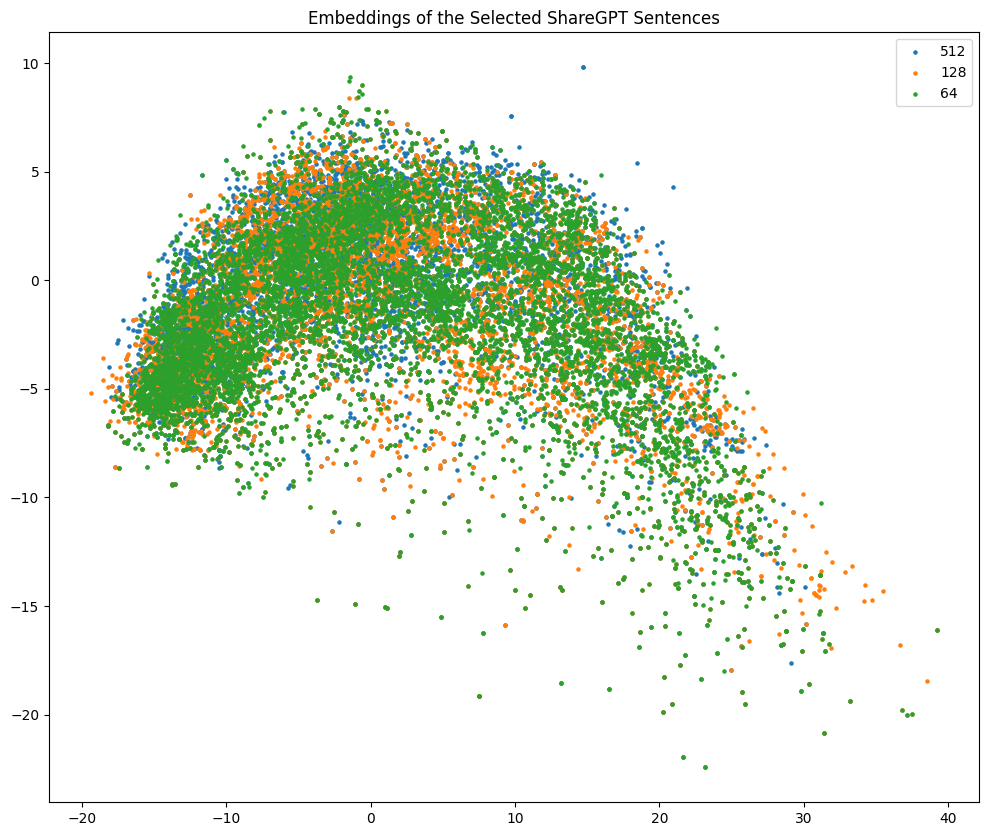

In [30]:
# plot the embeddings
fig, ax = plt.subplots(figsize=(12, 10))
for name, embeddings in indices2embeddings.items():
    ax.scatter(embeddings[:, 0], embeddings[:, 1], label=name, s=5)
ax.legend()
# title
plt.title('Embeddings of the Selected ShareGPT Sentences')

Text(0.5, 1.0, 'Deita Evol score distribution')

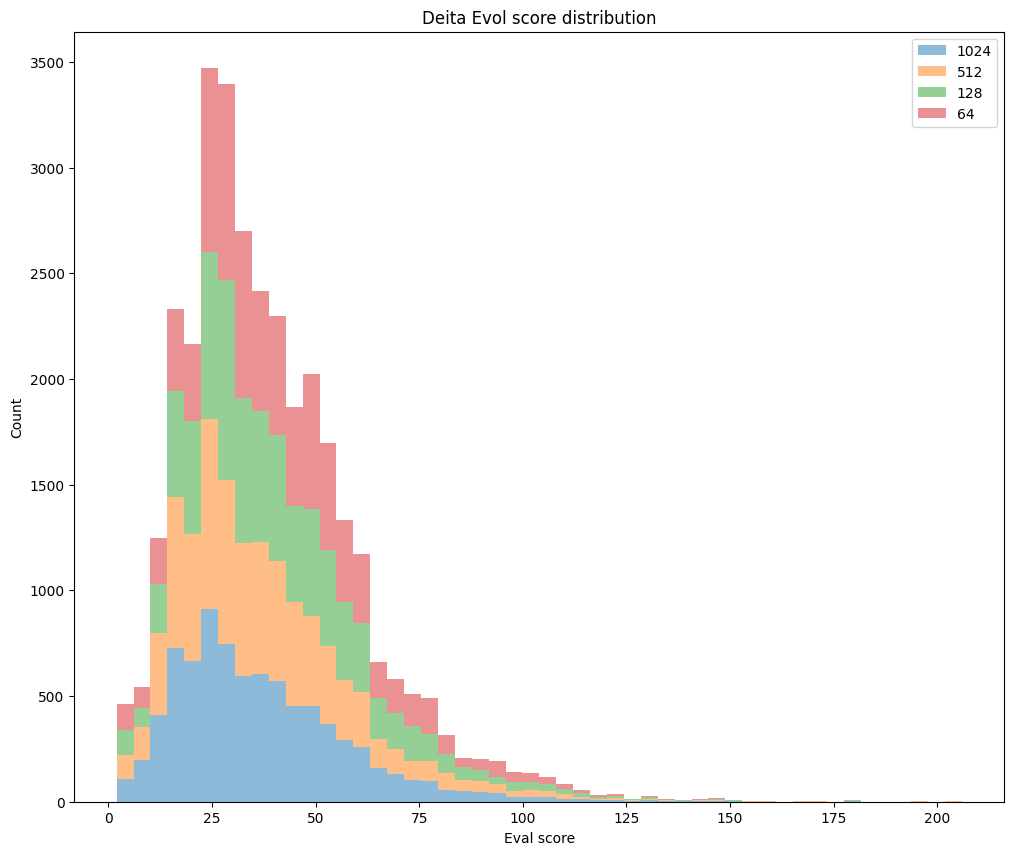

In [14]:
# plot the scores
eval_scores = np.array([score['eval_score'] for score in scores])
fig, ax = plt.subplots(figsize=(12, 10))
all_scores = []
names = []
for name, index in indices.items():
    index = np.array(index)
    name_scores = eval_scores[index]
    all_scores.append(name_scores)
    names.append(name)

# Plot the stacked histogram
ax.hist(all_scores, bins=50, label=names, alpha=0.5, stacked=True)
# ax.set_yscale('log')
ax.legend()
# x-axis title
ax.set_xlabel('Eval score')
# y-axis title
ax.set_ylabel('Count')
# title
ax.set_title('Deita Evol score distribution')